# Galaxy Zoo 2: ConvNeXt Curriculum Learning

This notebook demonstrates curriculum learning for the Galaxy Zoo 2 dataset using PyTorch and ConvNeXt. We reuse functions and classes from the original ConvNeXt notebook and implement a staged training process where the model is first trained on high-confidence examples, then gradually exposed to more ambiguous data.

## 1. Import Required Libraries and Utilities
Import all necessary libraries, including torch, torchvision, numpy, pandas, matplotlib, and any utility functions/classes reused from the original notebook.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, Subset
import os
from PIL import Image
from torchvision import transforms
import glob
import concurrent.futures
from torchvision.models import ConvNeXt_Tiny_Weights
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Define Image Preprocessing and Tensor Saving Functions
Reuse the image preprocessing and tensor saving functions from the original notebook.

In [ ]:
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def process_image(img_path_output_size):
    img_path, output_dir, size = img_path_output_size
    basename = os.path.splitext(os.path.basename(img_path))[0]
    out_path = os.path.join(output_dir, f"{basename}.pt")
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    left, top, right, bottom = 20, 20, width - 20, height - 20
    img_cropped = img.crop((left, top, right, bottom))
    img_resized = img_cropped.resize(size, Image.LANCZOS)
    tensor = transforms.ToTensor()(img_resized)
    tensor = norm(tensor)
    torch.save(tensor, out_path)

def save_tensor_images_threaded(input_dir, output_dir, size=(224, 224), num_workers=4):
    os.makedirs(output_dir, exist_ok=True)
    image_files = glob.glob(os.path.join(input_dir, '*.jpg'))
    print(f"Found {len(image_files)} images.")
    args = [(img_path, output_dir, size) for img_path in image_files]
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_image, args))
    for res in results[:20]:
        print(res)
    print(f"Finished saving tensors for {len(image_files)} images.")

## 3. Define GalaxyZooTensorDataset Class
Reuse the GalaxyZooTensorDataset class for loading preprocessed tensor images and labels.

In [ ]:
class GalaxyZooTensorDataset(Dataset):
    def __init__(self, csv_file, tensor_dir):
        self.tensor_dir = tensor_dir
        if csv_file is not None:
            self.df = pd.read_csv(csv_file)
            self.ids = self.df.iloc[:, 0].values
            self.labels = self.df.iloc[:, 1:].values.astype(np.float32)
            self.has_labels = True
        else:
            # For test set, infer IDs from tensor filenames
            self.df = None
            self.ids = [os.path.splitext(f)[0] for f in sorted(os.listdir(tensor_dir)) if f.endswith('.pt')]
            self.has_labels = False
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        galaxy_id = int(self.ids[idx])
        tensor_path = os.path.join(self.tensor_dir, f"{galaxy_id}.pt")
        image = torch.load(tensor_path, weights_only=True)
        if self.has_labels:
            labels = self.labels[idx]
            return image, labels
        else:
            return image, galaxy_id

## 4. Prepare Curriculum Learning Data Splits
We will split the training data into curriculum stages based on label confidence (maximum probability per sample). High-confidence samples will be used first, followed by medium and low-confidence samples.

In [ ]:
# Load training solutions and dataset
csv_file = './training_solutions_rev1/training_solutions_rev1.csv'
tensor_dir = './images_training_rev1/images_training_resized'
dataset = GalaxyZooTensorDataset(csv_file, tensor_dir)

# Compute confidence (max probability) for each sample
confidences = dataset.labels.max(axis=1)

# Define thresholds for curriculum stages
high_thresh = 0.94
med_thresh = 0.85

high_conf_idx = np.where(confidences >= high_thresh)[0]
med_conf_idx = np.where((confidences < high_thresh) & (confidences >= med_thresh))[0]
low_conf_idx = np.where(confidences < med_thresh)[0]

print(f"High confidence: {len(high_conf_idx)} samples")
print(f"Medium confidence: {len(med_conf_idx)} samples")
print(f"Low confidence: {len(low_conf_idx)} samples")

## 5. Create DataLoaders for Curriculum Stages
Create DataLoaders for each curriculum stage using the corresponding subset of the training data.

In [ ]:
batch_size = 128

high_conf_loader = DataLoader(Subset(dataset, high_conf_idx), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
med_conf_loader = DataLoader(Subset(dataset, np.concatenate([high_conf_idx, med_conf_idx])), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# For validation, split a portion from the full dataset
from torch.utils.data import random_split
total = len(dataset)
val_size = int(0.2 * total)
train_size = total - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

## 6. Load and Modify ConvNeXt Model
Load the ConvNeXt model, freeze all layers except the classifier, and modify the final layer to match the number of classes.

In [ ]:
convnext = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
num_classes = dataset.labels.shape[1]

# Freeze all parameters
for param in convnext.parameters():
    param.requires_grad = False

# Replace the final layer
in_features = convnext.classifier[2].in_features
convnext.classifier[2] = nn.Linear(in_features, num_classes)

# Unfreeze only the last layer of the classifier
for param in convnext.classifier[2].parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convnext = convnext.to(device)

## 7. Set Up Loss Function and Optimizer
Set up the BCEWithLogitsLoss and Adam optimizer, filtering parameters as in the original notebook.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, convnext.parameters()), lr=1e-4)

## 8. Train Model with Curriculum Learning Loop
Train the model sequentially on high-confidence, then medium, then all data. Track and print training loss for each stage.

In [ ]:
def train_one_stage(model, loader, optimizer, criterion, device, num_epochs=3, stage_name="Stage"):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_start = time.time()
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_loss = running_loss / len(loader.dataset)
        losses.append(avg_loss)
        print(f"{stage_name} Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Time={time.time()-epoch_start:.2f}s")
    return losses

## 9. Save Model Checkpoints

In [ ]:
def save_checkpoint(model, optimizer, train_losses, filename):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved as {filename}")

In [ ]:
train_losses = []

In [ ]:
print("Training on high-confidence samples...")
stage_name = "High_Confidence"
high_losses = train_one_stage(convnext, high_conf_loader, optimizer, criterion, device, num_epochs=5, stage_name=stage_name)
save_checkpoint(convnext, optimizer, train_losses, f"curriculum_checkpoint_{stage_name}.pth")
train_losses.extend(high_losses)

In [ ]:
print("Training on high+medium-confidence samples...")
stage_name = "Medium_Confidence"
med_losses = train_one_stage(convnext, med_conf_loader, optimizer, criterion, device, num_epochs=5, stage_name=stage_name)
save_checkpoint(convnext, optimizer, train_losses, f"curriculum_checkpoint_{stage_name}.pth")
train_losses.extend(med_losses)

In [ ]:
print("Training on all samples...")
stage_name = "All_data"
full_losses = train_one_stage(convnext, full_loader, optimizer, criterion, device, num_epochs=10, stage_name=stage_name)
save_checkpoint(convnext, optimizer, train_losses, f"curriculum_checkpoint_{stage_name}.pth")
train_losses.extend(full_losses)

## 10. Save Training Loss for Each Curriculum Stage

In [ ]:
loss_df = pd.DataFrame({'epoch': list(range(1, len(train_losses)+1)), 'loss': train_losses})
loss_df.to_csv('curriculum_train_losses.csv', index=False)
print('Training losses saved to curriculum_train_losses.csv')

## 11. Evaluate Model on Validation Set
After curriculum training, evaluate the model on the validation set and report relevant metrics.

In [ ]:
convnext.eval()
val_losses = []
all_preds = []
all_targets = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = convnext(images)
        loss = criterion(outputs, labels)
        val_losses.append(loss.item() * images.size(0))
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(labels.cpu().numpy())

val_loss = np.sum(val_losses) / len(val_loader.dataset)
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

print(f"Validation Loss: {val_loss:.4f}")

rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))
print(f"Validation RMSE: {rmse:.4f}")

## 12. Evaluate on test dataset and save submission

In [ ]:
test_dataset = GalaxyZooTensorDataset(csv_dir=None, tensor_dir='./images_test_rev1/images_test_resized')
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

convnext.eval()
all_predictions = []
all_galaxy_ids = []

with torch.no_grad():
    for images, galaxy_ids in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = convnext(images)
        probs = torch.sigmoid(outputs)
        all_predictions.append(probs.cpu().numpy())
        all_galaxy_ids.extend(galaxy_ids)

predictions = np.concatenate(all_predictions, axis=0)

columns = ['GalaxyId']
questions = {1: 3, 2: 2, 3: 2, 4: 2, 5: 4, 6: 2, 7: 3, 8: 7, 9: 3, 10: 3, 11: 6}
for q, count in questions.items():
    for i in range(1, count + 1):
        columns.append(f'Class{q}.{i}')

submission_df = pd.DataFrame(predictions, columns=columns[1:])
submission_df.insert(0, 'GalaxyId', all_galaxy_ids)
print(submission_df.head())
submission_df.to_csv('submission_curriculum.csv', index=False)

## 13. Plot results

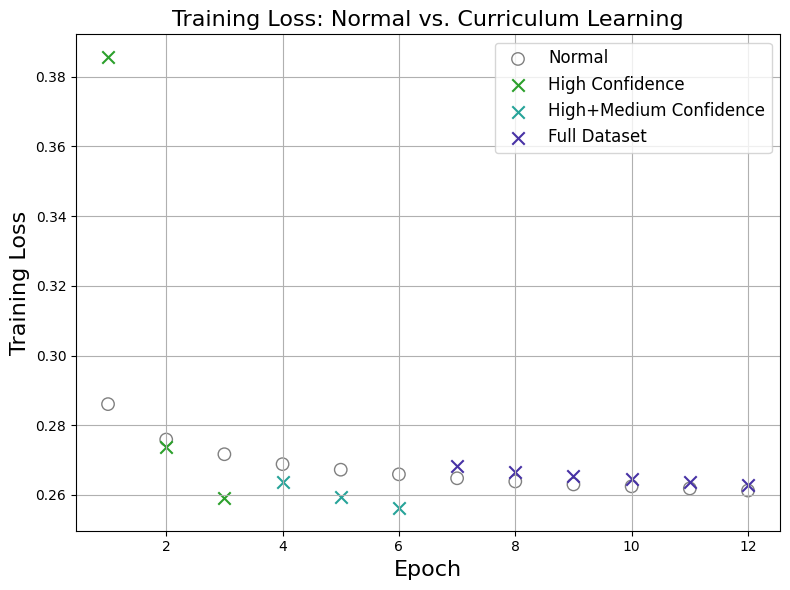

In [ ]:
# Load training losses from CSV files
normal_df = pd.read_csv('train_losses.csv')
curriculum_df = pd.read_csv('curriculum_train_losses.csv')

plt.figure(figsize=(8,6))
plt.scatter(normal_df['epoch'], normal_df['loss'], marker='o', s=80, facecolors='none', color='0.5', label='Normal')
plt.scatter(curriculum_df['epoch'][:3], curriculum_df['loss'][:3], marker='x', s=80, color="#2ca02c", label='High Confidence')
plt.scatter(curriculum_df['epoch'][3:6], curriculum_df['loss'][3:6], marker='x', s=80, color="#26a399", label='High+Medium Confidence')
plt.scatter(curriculum_df['epoch'][6:], curriculum_df['loss'][6:], marker='x', s=80, color="#4732a5", label='Full Dataset')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.title('Training Loss: Normal vs. Curriculum Learning', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()